In [2]:
!pip install prophet pandas


In [3]:
from google.colab import files

# Upload the CSV file first line 4 or 5
uploaded = files.upload()

# Confirm the filename (update this if needed after upload)
csv_filename = list(uploaded.keys())[0]
print(f"✅ Uploaded CSV file: {csv_filename}")

# Upload the PKL file next line 4 or 5
uploaded = files.upload()

# Confirm the filename (update this if needed after upload)
pkl_filename = list(uploaded.keys())[0]
print(f"✅ Uploaded PKL file: {pkl_filename}")


Saving line4.csv to line4.csv
✅ Uploaded CSV file: line4.csv


Saving prophet_r01.pkl to prophet_r01.pkl
✅ Uploaded PKL file: prophet_r01.pkl


In [4]:
import pandas as pd

# Load the CSV data
df = pd.read_csv(csv_filename)

# Ensure timestamp is datetime and fix timezone issues (remove timezone if present)
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
df['timestamp'] = df['timestamp'].dt.tz_localize(None)

print(f"✅ Loaded data, sample:\n{df.head()}")


✅ Loaded data, sample:
                   timestamp  r01  r02  r03  r04  r05  r06  r07  r08
0 2023-12-18 11:08:30.729978  207  408  367  414  315  353  425  337
1 2023-12-18 11:08:59.437992  207  408  366  414  314  353  421  338
2 2023-12-18 11:09:30.882165  207  408  368  415  314  353  421  338
3 2023-12-18 11:10:00.664021  207  408  370  412  313  353  423  338
4 2023-12-18 11:10:29.356050  207  408  370  410  313  352  419  337


In [7]:
import joblib

# Try loading the model using joblib instead of pickle
model = joblib.load(pkl_filename)

print(f"✅ Loaded Prophet model from: {pkl_filename}")


✅ Loaded Prophet model from: prophet_r01.pkl


In [8]:
# Prophet expects column 'ds' (date) — we are forecasting 'r01' so we need future timestamps
forecast_df = pd.DataFrame()
forecast_df['ds'] = df['timestamp']  # Only the timestamp column is needed for prediction

print(f"✅ Forecast dataframe prepared:\n{forecast_df.head()}")


✅ Forecast dataframe prepared:
                          ds
0 2023-12-18 11:08:30.729978
1 2023-12-18 11:08:59.437992
2 2023-12-18 11:09:30.882165
3 2023-12-18 11:10:00.664021
4 2023-12-18 11:10:29.356050


In [9]:
# Predict using the trained Prophet model
forecast = model.predict(forecast_df)

# Show forecast (ds = date, yhat = predicted value)
print(f"✅ Forecast complete:\n{forecast[['ds', 'yhat']].head()}")


✅ Forecast complete:
                          ds        yhat
0 2023-09-14 00:00:00.732823  137.706210
1 2023-09-14 00:00:30.749916  137.722676
2 2023-09-14 00:01:00.890020  137.739151
3 2023-09-14 00:01:31.025756  137.756203
4 2023-09-14 00:02:00.669910  137.772144


In [10]:
df_forecast = pd.merge(forecast[['ds', 'yhat']], df, left_on='ds', right_on='timestamp', how='left')

print(f"✅ Combined actual and predicted data:\n{df_forecast.head()}")


✅ Combined actual and predicted data:
                          ds        yhat                  timestamp  r01  r02  \
0 2023-09-14 00:00:00.732823  137.706210 2023-09-14 00:00:00.732823   56   85   
1 2023-09-14 00:00:30.749916  137.722676 2023-09-14 00:00:30.749916   57   85   
2 2023-09-14 00:01:00.890020  137.739151 2023-09-14 00:01:00.890020   57   85   
3 2023-09-14 00:01:31.025756  137.756203 2023-09-14 00:01:31.025756   56   85   
4 2023-09-14 00:02:00.669910  137.772144 2023-09-14 00:02:00.669910   57   85   

   r03  r04  r05  r06  r07  r08  
0   95  129  141  130  107   87  
1   95  129  141  130  107   87  
2   95  129  141  130  107   87  
3   95  129  141  130  107   87  
4   95  129  141  129  107   87  


In [11]:
# Step 8: Define traffic light logic
def get_traffic_light(value, mean_value, threshold=0.2):
    """Classify sensor value into traffic light color based on thresholds."""
    if abs(value - mean_value) <= (threshold * mean_value):
        return "Green"  # Normal
    elif abs(value - mean_value) <= (threshold * 2 * mean_value):
        return "Yellow"  # Slightly abnormal
    else:
        return "Red"  # Abnormal

# Step 9: Apply traffic light system to the forecasted data
mean_r01 = df['r01'].mean()  # Calculate mean of the 'r01' sensor for comparison
forecast['traffic_light'] = forecast['yhat'].apply(lambda x: get_traffic_light(x, mean_r01))

# Step 10: Show results
print(f"✅ Traffic Light Results:\n{forecast[['ds', 'yhat', 'traffic_light']].head()}")


✅ Traffic Light Results:
                          ds        yhat traffic_light
0 2023-09-14 00:00:00.732823  137.706210         Green
1 2023-09-14 00:00:30.749916  137.722676         Green
2 2023-09-14 00:01:00.890020  137.739151         Green
3 2023-09-14 00:01:31.025756  137.756203         Green
4 2023-09-14 00:02:00.669910  137.772144         Green


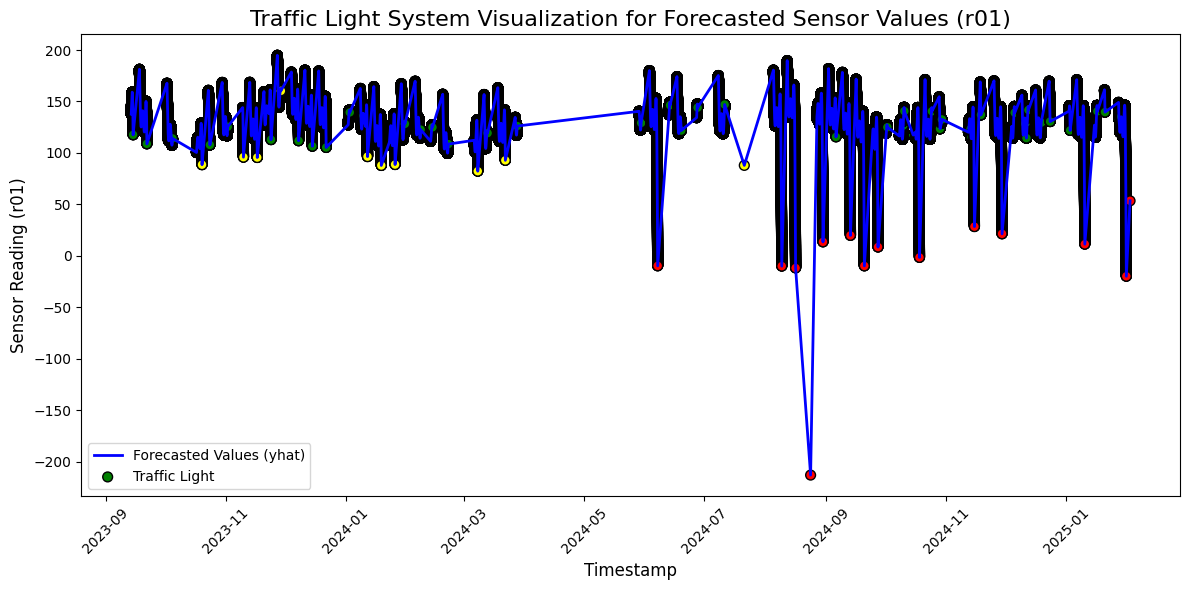

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Step 10: Visualize the forecast and traffic light system
plt.figure(figsize=(12, 6))

# Plot the forecasted 'yhat' values (predictions)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Values (yhat)', color='blue', linewidth=2)

# Plot traffic light colors for each forecasted value
colors = forecast['traffic_light'].map({
    'Green': 'green',
    'Yellow': 'yellow',
    'Red': 'red'
})

# Scatter plot with the traffic light colors
plt.scatter(forecast['ds'], forecast['yhat'], c=colors, label='Traffic Light', s=50, edgecolors='black')

# Add titles and labels
plt.title("Traffic Light System Visualization for Forecasted Sensor Values (r01)", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Sensor Reading (r01)", fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
